<a href="https://colab.research.google.com/github/ToniMarGar/Final_Project-Clothify/blob/main/Proyecto_final_test_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile

#Ruta al archivo .zip y la carpeta de destino
archivo_zip = 'Blouses_Shirts.zip'
carpeta_destino = '/content/Blouses_Shirts/'

#Descomprimir el archivo .zip
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

# Ruta a la carpeta con las imágenes
image_folder = '/content/Blouses_Shirts'

# Crear una lista para almacenar las imágenes preprocesadas
processed_images = []

# Iterar sobre los archivos en la carpeta
for img_file in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_file)

    # Cargar y procesar solo si el archivo es una imagen
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Cargar la imagen y redimensionarla a 224x224
        img = image.load_img(img_path, target_size=(256, 256))

        # Convertir la imagen a un array numpy
        img_array = image.img_to_array(img)

        # Expandir dimensiones para incluir batch size
        img_array = np.expand_dims(img_array, axis=0)

        # Preprocesar la imagen (normalización)
        img_array = preprocess_input(img_array)

        # Añadir a la lista de imágenes preprocesadas
        processed_images.append(img_array)

# Convertir la lista de imágenes preprocesadas en un array numpy
processed_images = np.vstack(processed_images)

print(f"Número de imágenes procesadas: {processed_images.shape[0]}")


Número de imágenes procesadas: 1426


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# Cargar el modelo preentrenado InceptionV3
base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)  # Usamos la capa de pooling global para los embeddings


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def extract_embedding(img_path, model):
    # Cargar la imagen
    img = image.load_img(img_path, target_size=(299, 299))  # Tamaño requerido por InceptionV3
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión (batch)
    img_array = preprocess_input(img_array)  # Preprocesar para InceptionV3

    # Obtener el embedding
    embedding = model.predict(img_array)
    return embedding.flatten()  # Aplanar el resultado


In [ ]:
def process_image_folder(folder_path, model):
    embeddings = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(('jpg', 'jpeg', 'png')):
            img_path = os.path.join(folder_path, filename)
            embeddings[filename] = extract_embedding(img_path, model)
    return embeddings


In [ ]:
# Carpeta con imágenes de blusas
image_folder = "/content/Blouses_Shirts"
database_embeddings = process_image_folder(image_folder, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar(query_embedding, database_embeddings):
    max_similarity = -1
    best_match = None
    for filename, embedding in database_embeddings.items():
        similarity = cosine_similarity([query_embedding], [embedding])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            best_match = filename
    return best_match, max_similarity


In [ ]:
# Subir una nueva imagen
query_image_path = "/efw.jpg"
query_embedding = extract_embedding(query_image_path, model)

# Buscar la imagen más similar
best_match, similarity_score = find_most_similar(query_embedding, database_embeddings)
print(f"La imagen más similar es: {best_match} con un puntaje de similitud de: {similarity_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
La imagen más similar es: id_00001932.jpg con un puntaje de similitud de: 0.8465255498886108


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


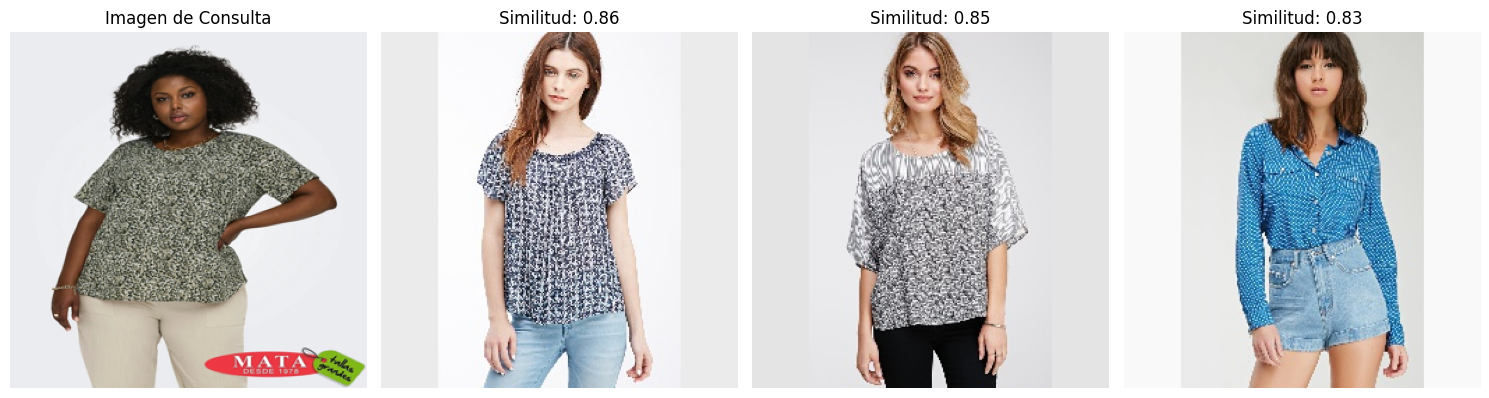

In [ ]:
import requests
from PIL import Image
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Función para procesar una imagen desde una URL y obtener embeddings
def extract_embedding_from_url(image_url, model):
    # Descargar la imagen desde la URL
    response = requests.get(image_url)
    if response.status_code == 200:
        # Abrir la imagen con Pillow
        img = Image.open(BytesIO(response.content))
        # Redimensionar la imagen al tamaño requerido por InceptionV3 (299x299)
        img = img.resize((299, 299))
        # Convertir la imagen a un array de NumPy
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión (batch)
        img_array = preprocess_input(img_array)  # Preprocesar para InceptionV3

        # Obtener el embedding
        embedding = model.predict(img_array)
        return embedding.flatten(), img  # Retornar el embedding y la imagen original
    else:
        raise Exception(f"Error al descargar la imagen: {response.status_code}")

# Función para encontrar las 3 imágenes más similares
def find_top_similar(query_embedding, database_embeddings, top_n=3):
    similarities = []
    for filename, embedding in database_embeddings.items():
        similarity = cosine_similarity([query_embedding], [embedding])[0][0]
        similarities.append((filename, similarity))
    # Ordenar por similitud en orden descendente
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]  # Retornar las top_n más similares

# Mostrar imágenes al usuario
def show_images(query_image, similar_images, image_folder):
    fig, axes = plt.subplots(1, len(similar_images) + 1, figsize=(15, 5))

    # Mostrar la imagen de consulta
    axes[0].imshow(query_image)
    axes[0].axis('off')
    axes[0].set_title("Imagen de Consulta")

    # Mostrar las imágenes similares
    for i, (filename, similarity) in enumerate(similar_images):
        img_path = os.path.join(image_folder, filename)
        img = Image.open(img_path)
        axes[i + 1].imshow(img)
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f"Similitud: {similarity:.2f}")

    plt.tight_layout()
    plt.show()

# URL de la imagen de consulta
query_image_url = "https://www.ropatallasgrandes.com/large/Blusa-mujer-tallas-grandes-24951-i24464.jpg"

# Extraer el embedding y cargar la imagen de consulta
query_embedding, query_image = extract_embedding_from_url(query_image_url, model)

# Encontrar las 3 imágenes más similares en la base de datos
top_similar_images = find_top_similar(query_embedding, database_embeddings, top_n=3)

# Mostrar las imágenes al usuario
image_folder = "/content/Blouses_Shirts"  # Carpeta con las imágenes de la base de datos
show_images(query_image, top_similar_images, image_folder)


1. Descomprimir el archivo ZIP

In [ ]:
import zipfile

# Ruta al archivo .zip y la carpeta de destino
archivo_zip = '/content/dataset.zip'
carpeta_destino = '/content'

# Descomprimir el archivo .zip
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_destino)


2. Preprocesar las imágenes y preparar el dataset

In [40]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración del generador de datos
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Escalar valores de píxeles
    validation_split=0.2  # Dividir datos para entrenamiento y validación
)

# Rutas
dataset_path = "/content/dataset"
target_size = (299, 299)

# Generadores de datos
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    subset='training',
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    subset='validation',
    class_mode='categorical'
)


Found 6382 images belonging to 23 classes.
Found 1585 images belonging to 23 classes.



3. Cargar el modelo preentrenado y hacer Fine-Tuning

In [41]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Cargar el modelo preentrenado
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Añadir capas personalizadas para clasificación de prendas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
prenda_output = Dense(train_generator.num_classes, activation='softmax', name='prenda_output')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=prenda_output)

# Congelar las capas base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 232ms/step - accuracy: 0.3924 - loss: 2.1359 - val_accuracy: 0.5022 - val_loss: 1.4792
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 152ms/step - accuracy: 0.5612 - loss: 1.2653 - val_accuracy: 0.5432 - val_loss: 1.3356
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.6152 - loss: 1.0986 - val_accuracy: 0.5893 - val_loss: 1.1923
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 158ms/step - accuracy: 0.6452 - loss: 0.9913 - val_accuracy: 0.5527 - val_loss: 1.2448
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.6596 - loss: 0.9417 - val_accuracy: 0.5527 - val_loss: 1.2337
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - accuracy: 0.6961 - loss: 0.8374 - val_accuracy: 0.5514 - val_loss: 1.2942
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - accuracy: 0.7190 - loss: 0.7717 - val_accuracy: 0.5697 - val_loss: 1.2336
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.7340 - loss: 0.7369 - val

4. Extraer embeddings para las prendas

In [39]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Desbloquear capas para extraer embeddings
for layer in base_model.layers:
    layer.trainable = True

# Crear un modelo para extraer embeddings
embedding_model = Model(inputs=base_model.input, outputs=x)

# Función para procesar una carpeta y generar embeddings
def generate_embeddings(folder_path, model):
    embeddings = []
    image_names = []
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = image.load_img(img_path, target_size=(299, 299))
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            embedding = model.predict(img_array)
            embeddings.append(embedding.flatten())
            image_names.append(img_file)
    return np.array(embeddings), image_names

# Generar embeddings
embeddings, image_names = generate_embeddings(dataset_path, embedding_model)
embeddings_dict = {name: embedding for name, embedding in zip(image_names, embeddings)}


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

5. Encontrar prendas similares a la imagen del usuario

In [65]:
import os
import requests
from PIL import Image
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity

# Función para descargar una imagen desde una URL y abrirla con PIL
def load_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        return img
    else:
        raise ValueError(f"Error al descargar la imagen desde la URL: {response.status_code}")

# Función para encontrar las prendas más similares
def find_top_similar(query_embedding, embeddings_dict, top_n=3):
    similarities = []
    for filename, embedding in embeddings_dict.items():
        similarity = cosine_similarity([query_embedding], [embedding])[0][0]
        similarities.append((filename, similarity))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Generar embedding para una imagen desde una URL
query_image_url = 'https://www.bolf.es/spa_pl_Pantalon-grueso-de-combate-joggers-de-chandal-para-hombre-negro-Bolf-JX8709A-89768_9.jpg'  # Cambia esta URL por la de tu imagen
query_image = load_image_from_url(query_image_url)

# Aquí puedes procesar la imagen (por ejemplo, redimensionarla o convertirla a un formato específico)
query_image_processed = query_image.resize((224, 224))  # Ajusta según lo que necesite tu modelo

# Guardar temporalmente la imagen procesada para usarla con el modelo (si es necesario)
query_image_path = '/tmp/query_image.jpg'
query_image_processed.save(query_image_path)

# Generar el embedding de la imagen de consulta
query_embedding, _ = generate_embeddings(os.path.dirname(query_image_path), embedding_model)

# Encontrar las prendas similares
top_similar_images = find_top_similar(query_embedding[0], embeddings_dict, top_n=3)
print(f"Prendas similares: {top_similar_images}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prendas similares: [('/content/dataset/Pants_M/id_00000470.jpg', 0.898185), ('/content/dataset/Denim_M/id_00003570.jpg', 0.8825593), ('/content/dataset/Pants_M/id_00003594.jpg', 0.8775128)]


7. Mostrar imágenes al usuario

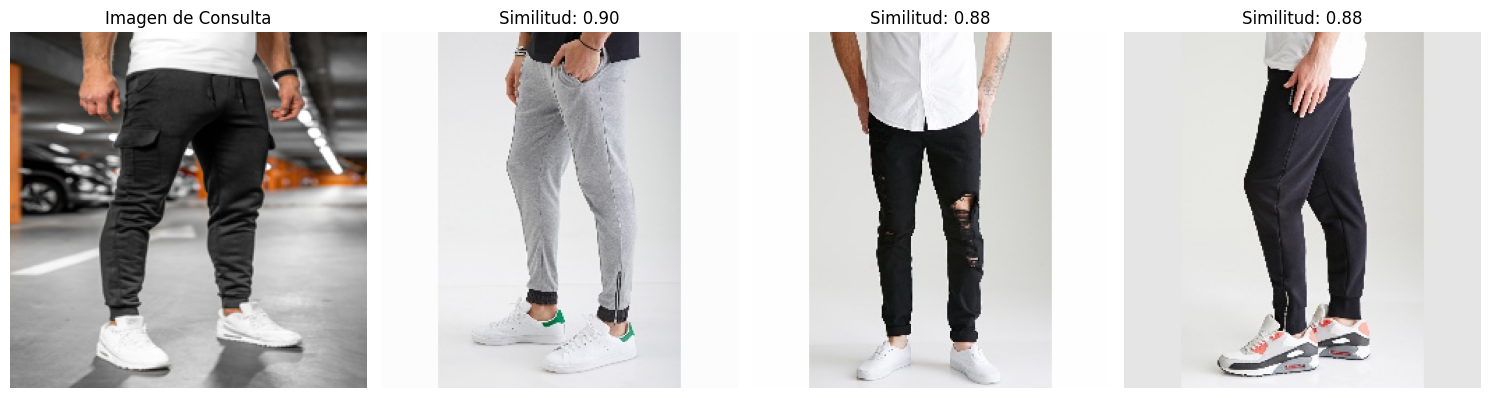

In [66]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_images(query_image, similar_images, dataset_path):
    fig, axes = plt.subplots(1, len(similar_images) + 1, figsize=(15, 5))

    # Mostrar imagen de consulta
    if isinstance(query_image, Image.Image):  # Verificar si es un objeto Image
        axes[0].imshow(query_image)
    else:  # Si no, asumir que es una ruta de archivo
        axes[0].imshow(Image.open(query_image))
    axes[0].axis('off')
    axes[0].set_title("Imagen de Consulta")

    # Mostrar imágenes similares
    for i, (filename, similarity) in enumerate(similar_images):
        img_path = os.path.join(dataset_path, filename)
        axes[i + 1].imshow(Image.open(img_path))
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f"Similitud: {similarity:.2f}")

    plt.tight_layout()
    plt.show()

# Mostrar las imágenes
# Asegúrate de que query_image sea un objeto Image o una ruta válida
show_images(query_image_processed, top_similar_images, dataset_path)
